In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1234)

# Exponential random numbers
## Define a function to generate exponential random numbers

In [2]:
def exponential_rng(lam=1.0):
    """ Generates exponential random numbers.
    
    Keywords:
        lam (float): the rate parameter, the inverse expectation of the distribution.
    
    Returns:
        exponential random numbers with rate lam.
    """
    return - np.log(1 - np.random.rand())/lam

## Test the function

In [3]:
exponential_rng() # Draw a sample from an exponential distribution

0.2125986576184801

## Generate draws and compare to theoretical density

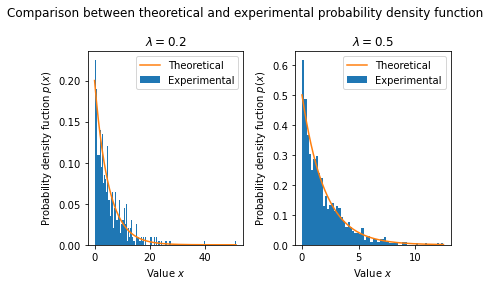

In [4]:
lam = [0.2, 0.5] # Vector of considered rates
n = 1000 # Number of samples to be drawn

draws = np.zeros((len(lam), n)) # Preallocate memory

fig, axs = plt.subplots(1, len(lam))
fig.suptitle('Comparison between theoretical and experimental probability density function')

for i, rate in enumerate(lam):
    for j in range(n):
        draws[i, j] = exponential_rng(rate) 
    # Plot the results using a normalized histogram
    axs[i].hist(x = draws[i, :], density = True, bins = int(5*draws[i, :].max()), label = 'Experimental')
    axs[i].set_title(f'$\lambda = {rate}$')
    
    x = np.linspace(0, draws[i, :].max(), 1000)
    axs[i].plot(x, rate*np.exp(-rate*x), label = 'Theoretical')

for ax in axs.flat:
    ax.set(xlabel = 'Value $x$', ylabel = 'Probability density fuction $p(x)$')
    ax.legend()

fig.tight_layout()

# Homogeneous Poisson process
## Define a function to generate arrivals according to Poisson process

In [5]:
def homogeneous_poisson_process(lam, T):
    """ Generates arrivals according to a Poisson process.
    
    Keywords:
        lam (float): the rate parameter, the inverse expectation of the distribution.
        T (int): duration of the Poisson process.
    
    Returns:
        times: arrival times of a Poisson process with rate lam until time T.
    """
    times = []
    t = exponential_rng(lam)
    while t <= T:
        times.append(t)
        t += exponential_rng(lam)
    return times

## Generate homogeneous Poisson process

In [6]:
lam = 4
T = 1
times = homogeneous_poisson_process(lam, T)

## Plot arrival times

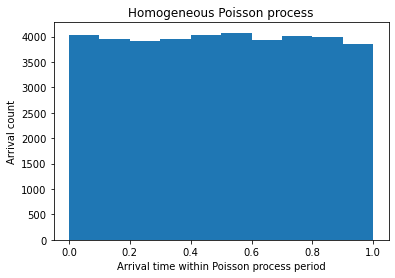

In [7]:
for i in range(10000):
    times.extend(homogeneous_poisson_process(lam, T))
    
plt.hist(times, density = False, bins = 10)
plt.xlabel('Arrival time within Poisson process period')
plt.ylabel('Arrival count')
plt.title('Homogeneous Poisson process')
plt.show()

# Nonhomogeneous Poisson process
## Define a function to generate arrivals according to non-homogeneous Poisson process

In [8]:
def non_homogeneous_poisson_process(lam_t, lam_max, T):
    """ Generates arrivals according to non-homogeneous Poisson process with time-dependent rate lam_t. 
    
    Keywords:
        lam_t (function handle): function returning the Poisson process rate at time t.
        lam_max (real): maximum value of lam_t(t) to be used for generating arrivals.
        T (int): duration of Poisson process.
    
    Returns:
        times: array of event times.
    """
    times = []
    t = exponential_rng(lam_max)
    while t <= T:
        # If an event occurs at time t, count it with probability p(t) = lam_t(t)/lam_max
        if np.random.rand() < lam_t(t)/lam_max:
            times.append(t)
        t += exponential_rng(lam_max)
    return times

## Generate nonhomogeneous poisson processes

In [9]:
lam_t = lambda t: lam*(1 + np.sin(t))
lam_max = 2*lam
T = 10
times = non_homogeneous_poisson_process(lam_t, lam_max, T)

## Plot arrival times

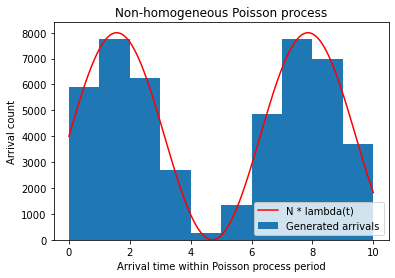

In [10]:
times = []
for _ in range(1000):
    times.extend(non_homogeneous_poisson_process(lam_t, lam_max, T))
    
plt.hist(times, density = False, bins=10, label='Generated arrivals')
plt.plot(np.linspace(0, 10, 1000), 1000*lam_t(np.linspace(0, 10, 1000)), 'r', label='N * lambda(t)')
plt.xlabel('Arrival time within Poisson process period')
plt.ylabel('Arrival count')
plt.title('Non-homogeneous Poisson process')
plt.legend()
plt.show()

## Extra questions
### Efficiency

In [11]:
def non_homogeneous_poisson_process_extra0(lam_t, lam_max, T):
    """ Generates arrivals according to non-homogeneous Poisson process with time-dependent rate lam_t. 
    
    Keywords:
        lam_t (function handle): function returning the Poisson process rate at time t
        lam_max (real): maximum value of lam_t(t) to be used for generating arrivals
        T (int): duration of Poisson process
    
    Returns:
        times: array of event times
        efficiency (real): (0-1) efficiency of non-homogeneous Poisson process 
    """
    times = []
    n = 0 # Internal counter for the total number of events registered during the whole duration T
    t = exponential_rng(lam_max)
    while t <= T:
        n += 1
        # If an event occurs at time t, count it with probability p(t) = lam_t(t)/lam_max
        if np.random.rand() < lam_t(t)/lam_max:
            times.append(t)
        t += exponential_rng(lam_max)
    return times, len(times)/n

Average efficiency = 0.5933270880263389


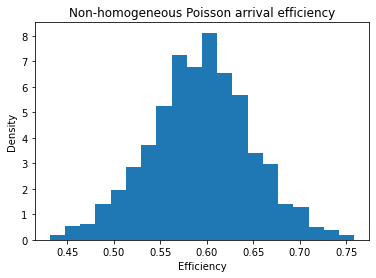

In [12]:
efficiency = []
for _ in range(1000):
    efficiency.append(non_homogeneous_poisson_process_extra0(lam_t, lam_max, T)[1])
    
plt.hist(efficiency, density = True, bins = 20)
plt.xlabel('Efficiency')
plt.ylabel('Density')
plt.title('Non-homogeneous Poisson arrival efficiency')
print(f'Average efficiency = {np.mean(efficiency)}')

### Piecewise lambda

In [13]:
def non_homogeneous_poisson_process_extra1(lam_t, lam_max, T):
    """ Generates arrivals according to non-homogeneous Poisson process with time-dependent rate lam_t. 
    
    Keywords:
        lam_t (function handle): function returning the Poisson process rate at time t
        lam_max (real): maximum value of lam_t(t) to be used for generating arrivals
        T (int): duration of Poisson process
    
    Returns:
        times: array of event times
        efficiency (real): (0-1) efficiency of non-homogeneous Poisson process 
    """
    times = []
    n = 0 # Internal counter for the total number of events registered during the whole duration T
    t = 0
    # Main loop
    while t <= T:
        # If sin(t) >= 0, lam_max/2 = lam <= lam_t <= 2*lam = lam_max
        # Use lam_max as rate for the associated homogeneous Poisson process
        if (math.floor(t/math.pi) %  2) == 0: 
            t_next = t + exponential_rng(lam_max)
            # If the next event occurs before the piecewise constant rate changes...
            if math.floor(t/math.pi) == math.floor(t_next/math.pi): 
                if t_next <= T:
                    t = t_next
                    n += 1
                    # If an event occurs at time t, count it with probability p(t) = lam_t(t)/lam_max
                    if np.random.rand() < lam_t(t)/(lam_max): 
                        times.append(t)
                else:
                    t = t_next; # Reached the duration of the process: will exit the main loop at the next iteration
            # ...otherwise move to the following interval of length \pi chacterised by a constant rate  
            else:
                t = (math.floor(t/math.pi) + 1)*math.pi 
        # If sin(t) <= 0, 0 <= lam_t <= lam = lam_max/2
        # Use lam_max/2 as rate for the associated homogeneous Poisson process 
        else: 
            t_next = t + exponential_rng(lam_max/2) 
            # If the next event occurs before the piecewise constant rate changes...
            if math.floor(t/math.pi) == math.floor(t_next/math.pi): 
                if t_next <= T:
                    t = t_next
                    n += 1
                    # If an event occurs at time t, count it with probability p(t) = lam_t(t)/lam_max
                    if np.random.rand() < lam_t(t)/(lam_max/2):
                        times.append(t)
                else:
                    t = t_next; # Reached the duration of the process: will exit the main loop at the next iteration
            # ...otherwise move to the following interval of length \pi chacterised by a constant rate  
            else: 
                t = (math.floor(t/math.pi) + 1)*math.pi 
                
    return times, len(times)/n

Average efficiency = 0.7254220943046945


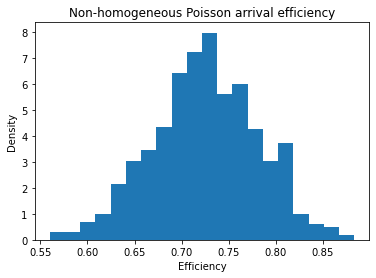

In [14]:
efficiency = []
for _ in range(1000):
    efficiency.append(non_homogeneous_poisson_process_extra1(lam_t, lam_max, T)[1])
    
plt.hist(efficiency, density = True, bins = 20)
plt.xlabel('Efficiency')
plt.ylabel('Density')
plt.title('Non-homogeneous Poisson arrival efficiency')
print(f'Average efficiency = {np.mean(efficiency)}')